<a href="https://colab.research.google.com/github/YoTaSo/datascience/blob/main/rl/MADDPG_multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/RLD/TME8'
os.chdir(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import matplotlib

#matplotlib.use("TkAgg")
import gym
import multiagent
import multiagent.scenarios
import multiagent.scenarios.simple_tag as simple_tag
import multiagent.scenarios.simple_tag as simple_spread
import multiagent.scenarios.simple_tag as simple_adversary
from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenarios
from gym import wrappers, logger
import numpy as np
import copy

from copy import deepcopy
import torch
from torch.optim import Adam
import torch.nn as nn
import numpy as np

class CriticNet(nn.Module):
    def __init__(self, dim_observation, dim_action):
        super(CriticNet, self).__init__()

        obs_dim = dim_observation
        act_dim = dim_action

        self.FC1 = nn.Linear(obs_dim, 1024)
        self.FC2 = nn.Linear(1024+act_dim, 512)
        self.FC3 = nn.Linear(512, 300)
        self.FC4 = nn.Linear(300, 1)

    # obs: batch_size * obs_dim
    def forward(self, obs, acts):
        result = torch.relu(self.FC1(obs))
        combined = torch.cat([result, acts], 1)
        out = torch.relu(self.FC2(combined))
        return self.FC4(torch.relu(self.FC3(out)))

class ActorNet(nn.Module):  
    def __init__(self, dim_observation, dim_action):
        super(ActorNet, self).__init__()

        self.FC1 = nn.Linear(dim_observation, 500)
        self.FC2 = nn.Linear(500, 128)
        self.FC3 = nn.Linear(128, dim_action)

    # action output between -1 and 1
    def forward(self, obs):
        result = torch.relu(self.FC1(obs))
        result = torch.relu(self.FC2(result))
        result = torch.tanh(self.FC3(result))
        return result


In [ ]:
from collections import namedtuple
import random

Experience = namedtuple('Experience', ('states', 'actions', 'next_states', 'rewards', 'dones'))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(Experience(*args))
        else:
            self.memory[self.position] = Experience(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [ ]:


def make_env(scenario_name, benchmark=False):
    from multiagent.environment import MultiAgentEnv
    import multiagent.scenarios as scenarios

    # load scenario from script
    scenario = scenarios.load(scenario_name + ".py").Scenario()
    # create world
    world = scenario.make_world()
    # create multiagent environment
    if benchmark:
        env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation, scenario.benchmark_data)
    else:
        env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
    return env


class MADDPG_Agent:
    def __init__(self, env, batch_size, replay_capacity, episodes_before_train, device='cpu'):

        self.env = env
        self.n_agents = env.n
        self.memory = ReplayMemory(replay_capacity)

        self.actors = [ActorNet(env.observation_space[i].shape[0], env.action_space[i].n) for i in range(self.n_agents)]
        self.critics = [CriticNet(env.observation_space[i].shape[0], env.n) for i in range(self.n_agents)]

        self.critic_optimizers = [Adam(x.parameters(), lr=0.01) for x in self.critics]
        self.actor_optimizers = [Adam(x.parameters(), lr=0.01) for x in self.actors]

        self.actor_targets = deepcopy(self.actors)
        self.critic_targets = deepcopy(self.critics)

        self.device = device
        self.episodes_before_train = episodes_before_train
        self.batch_size = batch_size

        self.GAMMA = 0.95
        self.epsilon = 0.3
        self.rewards_list=[]
        for x in self.actors:           x.to(device)
        for x in self.critics:          x.to(device)
        for x in self.actor_targets:    x.to(device)
        for x in self.critic_targets:   x.to(device)

    def select_actions(self, nets, states, noise=False):
        # TODO: actions as 1-hot arrays or logits or probabilities (FIND)
        actions = []
        for actor, state in zip(nets, states):
            state_v = torch.from_numpy(state).float().to(self.device)
            action = actor(state_v).data.cpu()
            if noise:
                action = action.numpy() + self.epsilon * np.random.normal(size=action.shape)
            else:
                action = action.numpy()
            action = np.clip(action, -1, 1)
            action_a = np.zeros(action.shape)
            action_a[action.argmax()] = 1
            actions.append(action_a)

        return actions

    def get_all_actions(self, nets, states_batch):
        # I know the select_actions() and get_all_actions() sound similar but I can't think of a good name
        next_actions = []
        for states in states_batch:
            actions = self.select_actions(nets, states)
            next_actions.append(actions)
        next_actions_a = np.array(next_actions).argmax(axis=2)
        all_next_actions_v = torch.from_numpy(next_actions_a).float().to(self.device)

        return all_next_actions_v

    def update(self, episodes_done):
        if episodes_done <= self.episodes_before_train:
            return

        sampled_batch = self.memory.sample(2)
        batch = Experience(*zip(*sampled_batch))

        states_batch = np.array(batch.states)
        actions_batch = np.array(batch.actions)
        next_states_batch = np.array(batch.next_states)
        rewards_batch = np.array(batch.rewards)
        dones_batch = np.array(batch.dones,dtype=bool)

        all_next_actions_v = self.get_all_actions(self.actor_targets, next_states_batch)
        all_actions_main_v = self.get_all_actions(self.actors, states_batch)
        all_actions_v = actions_batch.argmax(axis=2)
        all_actions_v = torch.from_numpy(all_actions_v).float().to(self.device)

        c_loss = []
        a_loss = []
        for agent in range(self.n_agents):
            self.critic_optimizers[agent].zero_grad()

            states_a = np.stack(states_batch[:, agent])
            actions_a = np.stack(actions_batch[:, agent])
            next_states_a = np.stack(next_states_batch[:, agent])
            rewards_a = np.stack(rewards_batch[:, agent]).reshape((2,1))
            dones_a = np.stack(dones_batch[:, agent]).reshape((2,1))

            next_states_v = torch.from_numpy(next_states_a).float().to(self.device)
            states_v = torch.from_numpy(states_a).float().to(self.device)
            rewards_v = torch.from_numpy(rewards_a).float().to(self.device)
            dones_v = torch.tensor(dones_a,dtype=bool).to(self.device)

            # update critic:
            Q_sa_target = self.critic_targets[agent](next_states_v, all_next_actions_v)
            Q_sa_target = Q_sa_target
            Q_sa_target[dones_v] = 0.0
            Y = rewards_v + self.GAMMA * Q_sa_target

            Q_sa = self.critics[agent](states_v, all_actions_v)

            critic_loss = nn.MSELoss()(Y, Q_sa.detach())
            critic_loss.backward()
            self.critic_optimizers[agent].step()

            # update actor:
            self.actor_optimizers[agent].zero_grad()
            action_i = self.actors[agent](states_v).data.cpu().numpy()
            action_i = action_i.argmax(axis=1)
            action_v = torch.from_numpy(action_i).float().to(self.device)
            all_actions_v[:, agent] = action_v
            actor_loss = -self.critics[agent](states_v, all_actions_v)
            actor_loss = actor_loss.mean()
            actor_loss.backward()
            self.actor_optimizers[agent].step()

            c_loss.append(critic_loss)
            a_loss.append(actor_loss)

        return (c_loss, a_loss)

    def soft_update(self, target, source, t):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_((1 - t) * target_param.data + t * source_param.data)

    def train(self, n_episodes, max_episode_length=100):
        total_steps = 0
        for i_episode in range(n_episodes):

            states = env.reset()
            steps = 0
            total_reward = 0
            for t in range(max_episode_length):
                #if i_episode % 100 == 0:
                 #   env.render()

                actions = self.select_actions(self.actor_targets, states, noise=True)
                next_states, rewards, dones, _ =  env.step(actions)
                total_reward += sum(rewards)

                if (t+1) == max_episode_length or all(dones):
                    dones = [1 for _ in range(env.n)]
                if not all(dones):
                    dones = [0 for _ in range(env.n)]

                self.memory.push(states, actions, next_states, rewards, dones)

                states = next_states
                self.update(i_episode)

                if total_steps % 100 == 0 and total_steps > 0:
                    for i in range(self.n_agents):
                        self.soft_update(self.actor_targets[i], self.actors[i], t=0.01)
                        self.soft_update(self.critic_targets[i], self.critics[i], t=0.01)

                if all(dones):
                    break

                steps += 1
                total_steps += 1

            print('Episode: %d, reward = %f' % (i_episode, total_reward))
            self.rewards_list.append(total_reward)


if __name__ == '__main__':
    device = 'cpu'
    #env = make_env('simple_tag')
    env = make_env('simple_spread')
    
    agent = MADDPG_Agent(env, 64, 10000, 10, device=device)
    agent.train(400, 200)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode: 0, reward = -7579.641993
Episode: 1, reward = -10644.395878
Episode: 2, reward = -5702.429955
Episode: 3, reward = -8738.563980
Episode: 4, reward = -8584.514477
Episode: 5, reward = -7635.793472
Episode: 6, reward = -6392.760200
Episode: 7, reward = -5984.347097
Episode: 8, reward = -9244.387583
Episode: 9, reward = -12387.949235
Episode: 10, reward = -7253.943904
Episode: 11, reward = -8921.847206
Episode: 12, reward = -8116.237669
Episode: 13, reward = -9480.072649
Episode: 14, reward = -8178.319909
Episode: 15, reward = -6729.959787
Episode: 16, reward = -9703.599607
Episode: 17, reward = -7261.507918
Episode: 18, reward = -7234.550147
Episode: 19, reward = -7693.202459
Episode: 20, reward = -8854.774815
Episode: 21, reward = -9323.034738
Episode: 22, reward = -9477.119942
Episode: 23, reward = -6520.406469
Episode: 24, reward = -7316.900125
Episode: 25, reward = -7837.749511
Episode: 26, reward = -6683.109049
Episode: 27, reward = -7061.890541
Episode: 28, reward = -7014.

KeyboardInterrupt: ignored

Text(0, 0.5, 'reward')

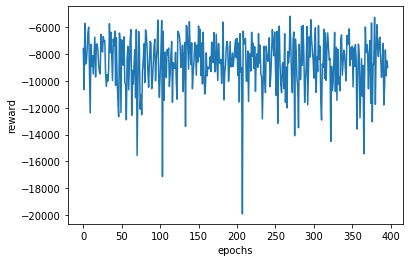

In [ ]:
import matplotlib.pyplot as plt
plt.plot(agent.rewards_list)
plt.xlabel("epochs")
plt.ylabel("reward")

In [ ]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [ ]:
import warnings
warnings.simplefilter("error")